USE GPU. I used Google colab environment

In [1]:
# Cell 1: Install dependencies
!pip install deepface tf-keras opencv-python scikit-learn matplotlib tqdm
import os

# Check if GPU is available (Optional but recommended for speed)
import tensorflow as tf
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.8 MB/s eta 0:00:00
GPU Available: []


In [3]:
# Cell 2: Unzip the dataset
import os
import shutil

zip_path = "Faces.zip"
extraction_root = "dataset"

# Clean up previous runs
if os.path.exists(extraction_root):
    shutil.rmtree(extraction_root)

# Unzip
if os.path.exists(zip_path):
    print("Unzipping Faces.zip...")
    !unzip -q {zip_path} -d {extraction_root}
    print("Unzip complete.")
else:
    print("Error: Faces.zip not found! Please upload it to Colab files.")

# Verify where the files are
print("\nRoot folder content:", os.listdir(extraction_root))

Unzipping Faces.zip...
Unzip complete.

Root folder content: ['FACES']


In [18]:
# Cell 3: Gentle Augmentation (Re-run this)
import os
import cv2
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# --- FIND DATA AGAIN ---
base_dir = "dataset"
input_dir = None
for root, dirs, files in os.walk(base_dir):
    if len(dirs) > 0:
        first_sub = os.path.join(root, dirs[0])
        if os.path.isdir(first_sub):
            images_in_sub = [f for f in os.listdir(first_sub) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if len(images_in_sub) > 0:
                input_dir = root
                break

if not input_dir:
    raise SystemExit("Stopping: Could not find images.")

augmented_dir = "augmented_dataset"
if os.path.exists(augmented_dir):
    shutil.rmtree(augmented_dir)
os.makedirs(augmented_dir)

# --- CHANGE: VERY MILD SETTINGS ---
# We reduced rotation from 10 to 5, and shift from 0.1 to 0.05
datagen = ImageDataGenerator(
    rotation_range=5,      # Reduced rotation
    width_shift_range=0.05, # Reduced shift
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1], # Less extreme lighting
    zoom_range=0.05,       # Less zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

print(f"Re-generating milder images from: {input_dir}")

for folder_name in tqdm(os.listdir(input_dir)):
    person_path = os.path.join(input_dir, folder_name)
    if not os.path.isdir(person_path): continue

    save_path = os.path.join(augmented_dir, folder_name)
    os.makedirs(save_path, exist_ok=True)

    images = [os.path.join(person_path, f) for f in os.listdir(person_path)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not images: continue

    for img_path in images:
        img = cv2.imread(img_path)
        if img is None: continue

        # Save original
        cv2.imwrite(os.path.join(save_path, os.path.basename(img_path)), img)

        # Generate fewer, higher quality variations (3 instead of 4)
        img = img.reshape((1,) + img.shape)
        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=save_path,
                                  save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= 3: break

print("✅ New gentle data created. NOW RUN CELL 4 AGAIN to extract new embeddings.")

Re-generating milder images from: dataset/FACES


100%|██████████| 52/52 [05:15<00:00,  6.07s/it]

✅ New gentle data created. NOW RUN CELL 4 AGAIN to extract new embeddings.


In [19]:
from deepface import DeepFace

X = [] # Embeddings
y = [] # Labels

print("Extracting embeddings... (This takes time)")

for person_folder in tqdm(os.listdir(augmented_dir)):
    person_path = os.path.join(augmented_dir, person_folder)
    if not os.path.isdir(person_path): continue

    # Clean Name Logic: Remove the "1-" or "2-" from the folder name
    parts = person_folder.split('-')
    if len(parts) > 1:
        clean_name = " ".join(parts[1:]) # "1-PRASHANT-YADAV" -> "PRASHANT YADAV"
    else:
        clean_name = person_folder

    for img_file in os.listdir(person_path):
        img_path = os.path.join(person_path, img_file)
        # Extract vector
        embedding_objs = DeepFace.represent(img_path=img_path,
                                            model_name="Facenet512", # Corrected capitalization
                                            enforce_detection=False)
        embedding = embedding_objs[0]["embedding"]
        X.append(embedding)
        y.append(clean_name)

print(f"\nExtraction Finished. Processed {len(X)} images.")

Extracting embeddings... (This takes time)


100%|██████████| 52/52 [24:43<00:00, 28.52s/it]


Extraction Finished. Processed 1036 images.


In [20]:
# Cell 5: Auto-Tuned Training (Grid Search)
import numpy as np
import pickle
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

X_data = np.array(X)
y_data = np.array(y)

if len(X_data) == 0:
    print("❌ ERROR: Run Cell 4 first!")
else:
    print(f"Optimizing model on {len(X_data)} images...")

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y_data)

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_encoded, test_size=0.2, random_state=42)

    # Define the pipeline
    pipe = Pipeline([
        ('normalizer', Normalizer(norm='l2')),
        ('clf', SVC(probability=True, class_weight='balanced'))
    ])

    # Define parameters to test (Grid Search)
    # This tries different math kernels to see which fits your faces best
    param_grid = {
        'clf__C': [0.1, 1, 10, 100],
        'clf__gamma': [1, 0.1, 0.01, 0.001],
        'clf__kernel': ['rbf', 'linear', 'poly']
    }

    # Find best model
    grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Get best model
    best_model = grid.best_estimator_

    # Test
    predictions = best_model.predict(X_test)
    acc = accuracy_score(y_test, predictions)

    print(f"\n✅ Optimization Complete!")
    print(f"Best Parameters: {grid.best_params_}")
    print(f"📊 New Accuracy: {acc * 100:.2f}%")

    # Save
    with open("face_model.pkl", "wb") as f:
        pickle.dump(best_model, f)
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(encoder, f)
    print("💾 Optimized model saved.")

Optimizing model on 1036 images...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

✅ Optimization Complete!
Best Parameters: {'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
📊 New Accuracy: 82.21%
💾 Optimized model saved.


1. Generating Embedding for test.jpg...
System Guess: VISHAL SINGH
--------------------------------
✅ CONFIRMED IDENTITY: VISHAL SINGH
📏 Distance Score: 0.1272 (Lower is better)
--------------------------------


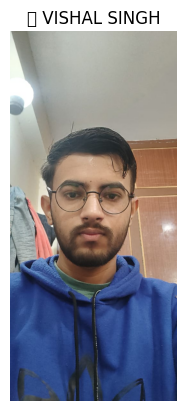

In [25]:
# Cell 6: Test with Distance Verification (The Robust Method)
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
from deepface import DeepFace
from scipy.spatial.distance import cosine

test_image_path = "test.jpg"

# Load resources
try:
    with open("face_model.pkl", "rb") as f:
        model = pickle.load(f)
    with open("label_encoder.pkl", "rb") as f:
        encoder = pickle.load(f)
except:
    print("❌ Model files missing. Run Cell 5 first.")
    raise SystemExit

if not os.path.exists(test_image_path):
    print(f"❌ Please upload '{test_image_path}'.")
else:
    try:
        print(f"1. Generating Embedding for {test_image_path}...")
        embedding_objs = DeepFace.represent(img_path=test_image_path,
                                            model_name="Facenet512",
                                            enforce_detection=True)
        test_embedding = embedding_objs[0]["embedding"]

        # 2. Ask SVM for the best guess
        test_input = np.array(test_embedding).reshape(1, -1)
        prediction_idx = model.predict(test_input)[0]
        predicted_name = encoder.inverse_transform([prediction_idx])[0]

        print(f"System Guess: {predicted_name}")

        # 3. VERIFICATION STEP (The "Double Check")
        # We look at the original embeddings we created in Cell 4
        # and calculate how close this new face is to the training faces of the predicted person.

        match_distances = []

        # Loop through our training data (X and y from Cell 4)
        # Note: We need X and y to still be in memory from Cell 4
        if 'X' not in globals() or 'y' not in globals():
            print("⚠️ Warning: X and y variables lost. Verification might be less accurate.")
            min_dist = 0.5 # Fallback
        else:
            # Get all embeddings that belong to the predicted person
            person_indices = [i for i, label in enumerate(y) if label == predicted_name]
            person_embeddings = [X[i] for i in person_indices]

            # Calculate Cosine Distance for each (Lower is better)
            for train_emb in person_embeddings:
                dist = cosine(test_embedding, train_emb)
                match_distances.append(dist)

            # Find the closest match among all their photos
            min_dist = min(match_distances)

        # 4. Final Decision Logic
        # For FaceNet512, a cosine distance < 0.4 is usually a strong match
        THRESHOLD_DISTANCE = 0.45

        print(f"--------------------------------")
        if min_dist < THRESHOLD_DISTANCE:
            print(f"✅ CONFIRMED IDENTITY: {predicted_name}")
            print(f"📏 Distance Score: {min_dist:.4f} (Lower is better)")
            title_text = f"✅ {predicted_name}"
        else:
            print(f"⛔ REJECTED: Face too different")
            print(f"Guess was {predicted_name}, but distance {min_dist:.4f} is too high.")
            title_text = "Unknown / Mismatch"
        print(f"--------------------------------")

        # Display
        img = cv2.imread(test_image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(title_text)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"❌ Error: {e}")